In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
import geopandas
import json
from shapely.geometry import shape
warnings.filterwarnings("ignore")

In [2]:
availability_data = pd.read_csv("Data/compressedRawData.csv", index_col=0)
availability_data = availability_data[["datetime","b_number","trip","p_lat","p_lng","p_name","p_bikes", "city"]]
availability_data["datetime"] = pd.to_datetime(availability_data["datetime"])
availability_data["month"] = availability_data["datetime"].apply(lambda x: x.month)
availability_data["day"] = availability_data["datetime"].apply(lambda x: x.day)
availability_data["hour"] = availability_data["datetime"].apply(lambda x: x.hour)
availability_data.head()

,datetime,b_number,trip,p_lat,p_lng,p_name,p_bikes,city,month,day,hour
0,2019-01-20 00:00:00,44728,first,50.751759,7.119809,BIKE 44728,1,bonn,1,20,0
1,2019-01-20 23:59:00,44728,last,50.751840,7.119686,BIKE 44728,1,bonn,1,20,23
2,2019-01-20 00:00:00,44952,first,50.703280,7.154667,BIKE 44952,1,bonn,1,20,0
3,2019-01-20 03:20:00,44952,start,50.703284,7.154586,BIKE 44952,1,bonn,1,20,3
4,2019-01-20 03:37:00,44952,end,50.716569,7.160905,BIKE 44952,1,bonn,1,20,3


In [3]:
from h3 import h3 
def createHexagons(df, resolution = 8):    
    df["h3_hex_id"] = df.apply(lambda row: h3.geo_to_h3(row["p_lat"], row["p_lng"], resolution) if (row['p_lat'] and row['p_lng']) else 0, axis=1)
    return df

In [4]:
availability_data = createHexagons(availability_data,7)
availability_data

,datetime,b_number,trip,p_lat,p_lng,p_name,p_bikes,city,month,day,hour,h3_hex_id
0,2019-01-20 00:00:00,44728,first,50.751759,7.119809,BIKE 44728,1,bonn,1,20,0,871fa1115ffffff
1,2019-01-20 23:59:00,44728,last,50.751840,7.119686,BIKE 44728,1,bonn,1,20,23,871fa1115ffffff
2,2019-01-20 00:00:00,44952,first,50.703280,7.154667,BIKE 44952,1,bonn,1,20,0,871fa11adffffff
3,2019-01-20 03:20:00,44952,start,50.703284,7.154586,BIKE 44952,1,bonn,1,20,3,871fa11adffffff
4,2019-01-20 03:37:00,44952,end,50.716569,7.160905,BIKE 44952,1,bonn,1,20,3,871fa111effffff
...,...,...,...,...,...,...,...,...,...,...,...,...
2596257,2019-12-31 23:59:00,45245,last,50.730347,7.114112,BIKE 45245,1,bonn,12,31,23,871fa1110ffffff
2596258,2019-12-31 18:17:00,44718,first,50.669920,7.185788,"50.670171, 7.186199",1,bonn,12,31,18,871fa1036ffffff
2596259,2019-12-31 19:12:00,44718,start,50.669920,7.185803,"50.670171, 7.186199",1,bonn,12,31,19,871fa1036ffffff
2596260,2019-12-31 19:14:00,44718,end,50.670884,7.185775,BIKE 44718,1,bonn,12,31,19,871fa1036ffffff


In [5]:
def get_timebasket(hour):
    #from 5.00 to 10.59 : Morning
    if hour>4 and hour<11:
        x=0
        
    #from 11.00 to 12.59 : noon
    if hour>10 and hour<13:
        x=1
    
    #from 13.00 to 17.59 : afternoon
    if hour>12 and hour<18:
        x=2
    
    #from 18.00 to 22.59 : evening
    if hour>17 and hour<23:
        x=3
    
    #from 23.00 to 4.59 : night
    if hour>22 or hour<5:
        x=4
    return x


In [6]:
#availability_data["time_basket"] = availability_data["hour"].apply(lambda x: get_timebasket(x))

In [7]:
availability_data

,datetime,b_number,trip,p_lat,p_lng,p_name,p_bikes,city,month,day,hour,h3_hex_id,time_basket
0,2019-01-20 00:00:00,44728,first,50.751759,7.119809,BIKE 44728,1,bonn,1,20,0,871fa1115ffffff,4
1,2019-01-20 23:59:00,44728,last,50.751840,7.119686,BIKE 44728,1,bonn,1,20,23,871fa1115ffffff,4
2,2019-01-20 00:00:00,44952,first,50.703280,7.154667,BIKE 44952,1,bonn,1,20,0,871fa11adffffff,4
3,2019-01-20 03:20:00,44952,start,50.703284,7.154586,BIKE 44952,1,bonn,1,20,3,871fa11adffffff,4
4,2019-01-20 03:37:00,44952,end,50.716569,7.160905,BIKE 44952,1,bonn,1,20,3,871fa111effffff,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2596257,2019-12-31 23:59:00,45245,last,50.730347,7.114112,BIKE 45245,1,bonn,12,31,23,871fa1110ffffff,4
2596258,2019-12-31 18:17:00,44718,first,50.669920,7.185788,"50.670171, 7.186199",1,bonn,12,31,18,871fa1036ffffff,3
2596259,2019-12-31 19:12:00,44718,start,50.669920,7.185803,"50.670171, 7.186199",1,bonn,12,31,19,871fa1036ffffff,3
2596260,2019-12-31 19:14:00,44718,end,50.670884,7.185775,BIKE 44718,1,bonn,12,31,19,871fa1036ffffff,3


In [17]:
grouped_data = availability_data.groupby(["h3_hex_id", "month","day","hour"]).sum()
grouped_data.reset_index(inplace=True)
grouped_data = grouped_data[["h3_hex_id", "month","day","p_bikes","hour"]]
grouped_data

,h3_hex_id,month,day,p_bikes,hour
0,871e1e2a6ffffff,9,1,3,11
1,871ea8ba8ffffff,9,1,2,11
2,871f125b6ffffff,10,29,1,7
3,871f12c82ffffff,12,14,1,15
4,871f12c82ffffff,12,14,1,23
...,...,...,...,...,...
170745,871fa56e5ffffff,6,27,1,15
170746,871fa5713ffffff,8,27,1,11
170747,871fa5841ffffff,10,11,1,9
170748,871faeb40ffffff,10,23,1,5


In [8]:
# grouped_data = availability_data.groupby(["h3_hex_id","time_basket", "month","day"]).sum()
# grouped_data.reset_index(inplace=True)
# grouped_data = grouped_data[["h3_hex_id","time_basket", "month","day","p_bikes"]]
# grouped_data

,h3_hex_id,time_basket,month,day,p_bikes
0,871e1e2a6ffffff,1,9,1,3
1,871ea8ba8ffffff,1,9,1,2
2,871f125b6ffffff,0,10,29,1
3,871f12c82ffffff,2,12,14,1
4,871f12c82ffffff,4,12,14,1
...,...,...,...,...,...
49850,871fa56e5ffffff,2,6,27,1
49851,871fa5713ffffff,1,8,27,1
49852,871fa5841ffffff,0,10,11,1
49853,871faeb40ffffff,0,10,23,1


In [6]:
def centroid(h3hexId):
    vertexes = h3.h3_to_geo_boundary(h3hexId)
    _x_list = [vertex [0] for vertex in vertexes]
    _y_list = [vertex [1] for vertex in vertexes]
    _len = len(vertexes)
    _x = sum(_x_list) / _len
    _y = sum(_y_list) / _len
    return _x, _y

In [59]:
h3.h3_to_geo_boundary("871f125b6ffffff")

[[51.2898878293105, 7.196619141226558],
 [51.27846120857812, 7.198478967972951],
 [51.27468617673456, 7.216149427044347],
 [51.28233752012432, 7.231965668051162],
 [51.29376513580093, 7.2301109822044385],
 [51.2975404135495, 7.212434913245016]]

In [60]:
x = []
y = []
for i in range(0,6): 
    x.append(h3.h3_to_geo_boundary("871f125b6ffffff")[i][0])
    
for i in range(0,6): 
    y.append(h3.h3_to_geo_boundary("871f125b6ffffff")[i][1])

In [61]:
x

[51.2898878293105,
 51.27846120857812,
 51.27468617673456,
 51.28233752012432,
 51.29376513580093,
 51.2975404135495]

In [62]:
y

[7.196619141226558,
 7.198478967972951,
 7.216149427044347,
 7.231965668051162,
 7.2301109822044385,
 7.212434913245016]

In [63]:
array = centroid(h3.h3_to_geo_boundary("871f125b6ffffff"))
x.append(array[0])
y.append(array[1])

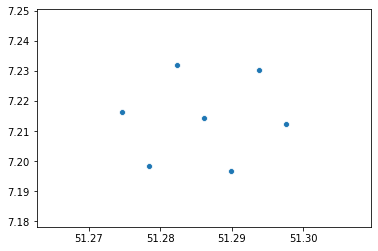

In [64]:
sns.scatterplot(x,y)

In [18]:
grouped_data["center"] = grouped_data["h3_hex_id"].apply(lambda x: centroid(x))

In [21]:
grouped_data["center_x"] = grouped_data["center"].apply(lambda x: x[0])
grouped_data["center_y"]  = grouped_data["center"].apply(lambda x: x[1])

In [22]:
grouped_data

,h3_hex_id,month,day,p_bikes,hour,center,center_x,center_y
0,871e1e2a6ffffff,9,1,3,11,"(45.8111182309292, 17.917651220545082)",45.811118,17.917651
1,871ea8ba8ffffff,9,1,2,11,"(44.41290082203329, 16.238714409989523)",44.412901,16.238714
2,871f125b6ffffff,10,29,1,7,"(51.28611304734965, 7.214293183290745)",51.286113,7.214293
3,871f12c82ffffff,12,14,1,15,"(51.503118148091694, 7.281557772396705)",51.503118,7.281558
4,871f12c82ffffff,12,14,1,23,"(51.503118148091694, 7.281557772396705)",51.503118,7.281558
...,...,...,...,...,...,...,...,...
170745,871fa56e5ffffff,6,27,1,15,"(51.02836865992858, 6.661864397414559)",51.028369,6.661864
170746,871fa5713ffffff,8,27,1,11,"(51.113855005652226, 6.359047910419005)",51.113855,6.359048
170747,871fa5841ffffff,10,11,1,9,"(51.78591568642514, 6.445856836687816)",51.785916,6.445857
170748,871faeb40ffffff,10,23,1,5,"(50.33079729122084, 8.784502863888331)",50.330797,8.784503


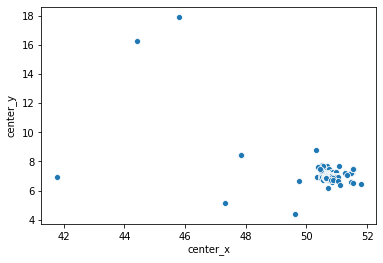

In [23]:
sns.scatterplot(grouped_data["center_x"], grouped_data["center_y"])

In [24]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = grouped_data[["month","day","hour","center_x","center_y"]]
y = grouped_data["p_bikes"]

X_train , X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=0)

svr = SVR("rbf")
svr.fit(scaler.fit_transform(X_train),y_train)
y_pred = svr.predict(scaler.fit_transform(X_test))

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('\n','R2: ', r2, '\n','Mean absolute error: ', mae,'\n','Mean squared error: ', mse )


 R2:  0.04860881486941837 
 Mean absolute error:  12.254907611476503 
 Mean squared error:  828.5231712200668


In [46]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = grouped_data[["time_basket","month","day","center_x","center_y"]]
y = grouped_data["p_bikes"]

X_train , X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=0)

svr = SVR("rbf", epsilon=10)
svr.fit(scaler.fit_transform(X_train),y_train)
y_pred = svr.predict(scaler.fit_transform(X_test))

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('\n','R2: ', r2, '\n','Mean absolute error: ', mae,'\n','Mean squared error: ', mse )



 R2:  -0.060087304549937715 
 Mean absolute error:  47.265184956836165 
 Mean squared error:  9566.099075762986


In [44]:
grouped_data.describe()

,time_basket,month,day,p_bikes,hex_number
count,49855.000000,49855.000000,49855.000000,49855.000000,49855.000000
mean,2.099067,6.938121,16.030408,56.136977,83.260195
std,1.435231,3.161796,8.858484,95.309390,43.817538
min,0.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,4.000000,8.000000,5.000000,49.000000
50%,2.000000,7.000000,16.000000,23.000000,70.000000
75%,3.000000,10.000000,24.000000,67.000000,100.000000
max,4.000000,12.000000,31.000000,2548.000000,212.000000
